##### imports 

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 

##### data

In [3]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1002,A1015 and E1034 have 4 or fewer data points
df = df[~((df['ID'] == 'A1009') & (df['sum_tumor_lengths'] == 10))] 
#remove the last point (10mm)as it is a single lymph node 5 days after previous scan -add to previous instead)
# Add 10 to the value at row 68 and column 1 as dates should be combined
df.iloc[68, 1] = df.iloc[68, 1] + 10
df.iloc[68,2] = df.iloc[68,2] + 167 


df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1003,A1015 and E1034 have 4 or fewer data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]

##### functions 

In [23]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    log_arg = kmax/(Spop + Rpop + epsilon) # stop division by 0

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops-data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error


##### fitting model

In [27]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

# fitting patient data to equations (r,Kmax,lamda,spop,rpop)
    
    # these are not bad - don't delete yet
    bounds = [(1e-3, 2e-1), (data[0], 1e4), (1e-1, 5),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 3*data[0],3, data[0]-1e-3, 1e-3]

    #trying these
    bounds = [(1e-3, 2e-1), (data[0], 1e4), (1, 20),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 3*data[0],3, data[0]-1e-3, 1e-3]

    opt_result_log = minimize(cost_func_gompertizian, init_params, 
                              args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun] 


Working on patient: A1002  Number of data points: 16


C:\Users\lstocker\AppData\Local\Temp\ipykernel_31460\3676105221.py:44: RuntimeWarning: overflow encountered in square
  sumsq_error = np.sum((sum_pops-data)**2)


Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


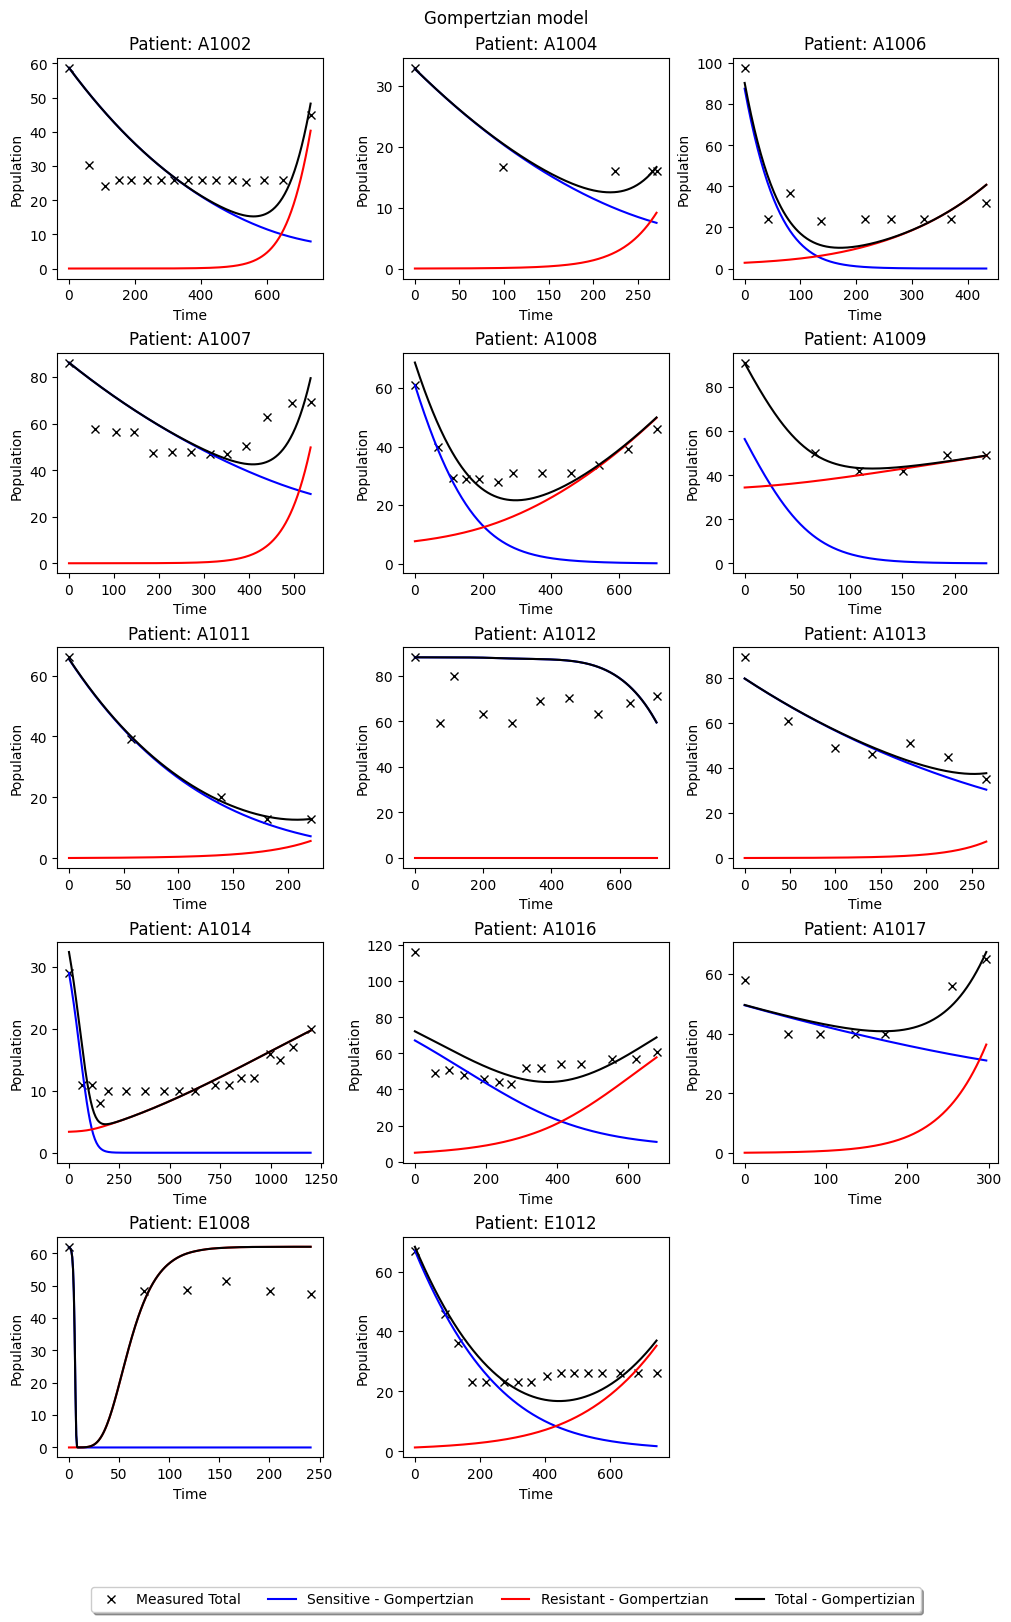

In [28]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [26]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.003998,1484.427111,1.171486,58.698957,0.000343,107.973596
A1004,0.007959,390.628393,1.223004,32.813783,0.012405,5.360187
A1006,0.001000,10000.000000,4.549096,87.774794,2.835446,130.233753
A1007,0.004324,5055.349710,1.102142,86.156117,0.001499,131.132723
A1008,0.001002,446.054573,4.222655,61.000000,7.663746,33.567922
A1009,0.027369,91.000000,1.426645,73.117338,0.988975,88.177736
A1011,0.003292,8300.084676,1.522692,65.404714,0.084013,0.640331
A1012,0.030776,88.000000,1.173761,84.160780,0.671539,124.557214
A1013,0.004254,8430.375009,1.167181,79.560370,0.022771,46.762779
A1014,0.001005,114.721731,4.997407,29.000000,1.137130,16.406461
